In [1]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
len(words)

32033

In [3]:
for w in words[:3]:
    print(w)
    chs = list('.'+w+'.')
    bigram = []
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram.append((ch1, ch2))
    for ch1, ch2 in zip(bigram, chs[2:]):
        print(ch1, ch2)

emma
('.', 'e') m
('e', 'm') m
('m', 'm') a
('m', 'a') .
olivia
('.', 'o') l
('o', 'l') i
('l', 'i') v
('i', 'v') i
('v', 'i') a
('i', 'a') .
ava
('.', 'a') v
('a', 'v') a
('v', 'a') .


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
trigram = {}

for w in words:
    chs = list('.'+w+'.')
    bigram = []
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram.append((ch1, ch2))
    for ch1, ch2 in zip(bigram, chs[2:]):
        trigram[(ch1, ch2)] = trigram.get((ch1, ch2), 0) + 1

In [6]:
counts = []
for x in trigram:
    counts.append(trigram.get(x))

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

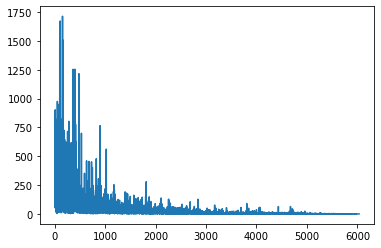

In [8]:
plt.plot(counts)

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [10]:
trigram2 = {}
for t in trigram:
    k = t[0]
    v = trigram2.get(k, {})
    v[t[1]] = trigram.get(t)
    trigram2[k] = v

In [11]:
sorted_trigram2 = sorted(trigram2.items(), key = lambda kv: kv[0])

In [12]:
sorted_trigram2[0]

(('.', 'a'),
 {'v': 243,
  'm': 384,
  'b': 190,
  'r': 482,
  'd': 366,
  'u': 152,
  'n': 623,
  'a': 207,
  'l': 632,
  't': 72,
  's': 194,
  'y': 173,
  'i': 154,
  'p': 17,
  'z': 152,
  'k': 75,
  'g': 17,
  'o': 10,
  'f': 21,
  'h': 91,
  'c': 31,
  'j': 27,
  'e': 55,
  'w': 6,
  'q': 9,
  'x': 27})

In [13]:
import torch
import torch.nn.functional as F

In [14]:
t_rows = len(sorted_trigram2)
N = torch.zeros((t_rows, 27), dtype=torch.int32)
N.shape

torch.Size([601, 27])

In [15]:
d_rows = {}
for i, data in enumerate(sorted_trigram2):
    d_rows[data[0]] = i
    for d in data[1].items():
        col = stoi[d[0]]
        N[i, col] = d[1]

In [16]:
N

tensor([[  0, 207, 190,  ...,  27, 173, 152],
        [  0, 169,   0,  ...,   0,   4,   0],
        [  0, 628,   0,  ...,   0,  46,   2],
        ...,
        [  1,   0,   0,  ...,   0,   0,   0],
        [ 34,  27,   0,  ...,   0,   0,   1],
        [  4,  13,   0,  ...,   0,   7,   0]], dtype=torch.int32)

(-0.5, 26.5, 199.5, -0.5)

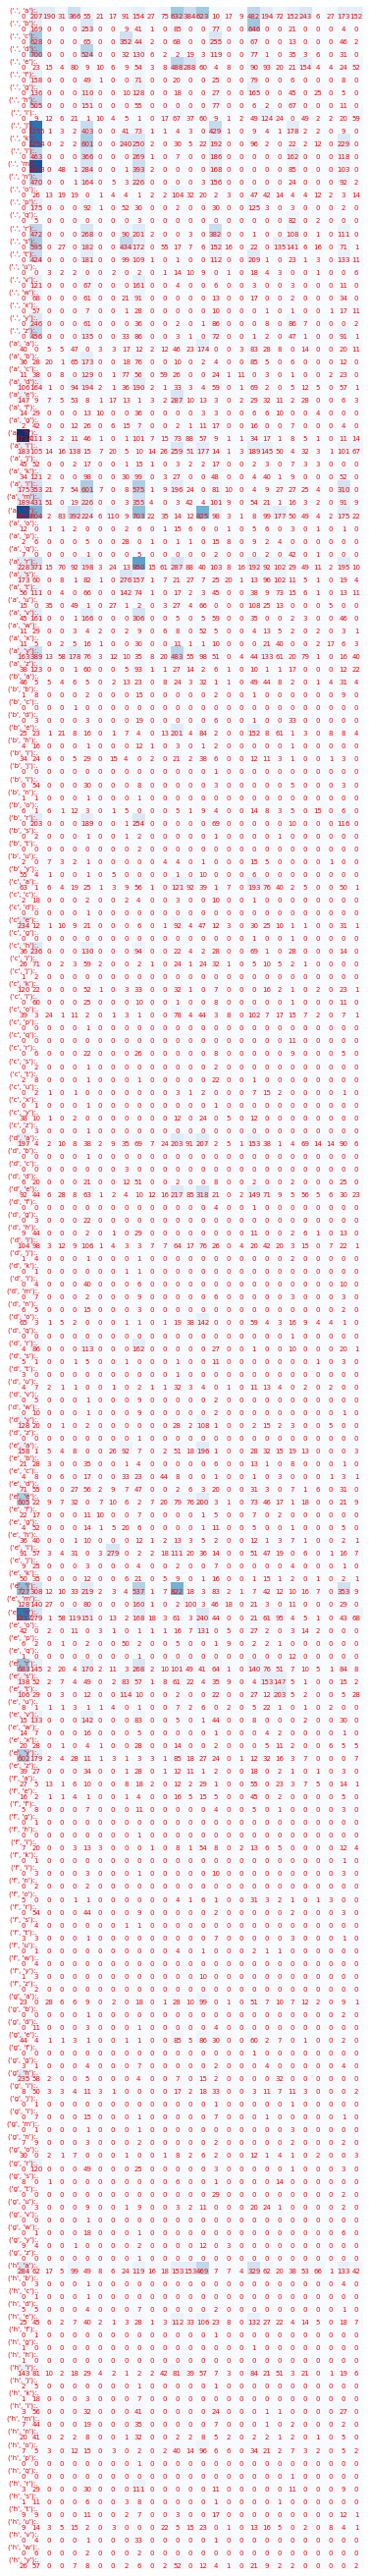

In [17]:
plt.figure(figsize=(48,48))
rs = 200
plt.imshow(N[:rs], cmap='Blues')
for i in range(rs):
    for j in range(27):
        chstr = str(sorted_trigram2[i][0])+ ':' + itos[j]
        if j == 0: plt.text(j, i, chstr, ha="center", va="bottom", color='red', fontsize=7)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='red', fontsize=7)
plt.axis('off')

In [18]:
N[0]

tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
        623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
       dtype=torch.int32)

In [19]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [20]:
P

tensor([[2.2538e-04, 4.6879e-02, 4.3047e-02,  ..., 6.3106e-03, 3.9216e-02,
         3.4483e-02],
        [7.5019e-04, 1.2753e-01, 7.5019e-04,  ..., 7.5019e-04, 3.7509e-03,
         7.5019e-04],
        [6.3735e-04, 4.0089e-01, 6.3735e-04,  ..., 6.3735e-04, 2.9955e-02,
         1.9120e-03],
        ...,
        [7.1429e-02, 3.5714e-02, 3.5714e-02,  ..., 3.5714e-02, 3.5714e-02,
         3.5714e-02],
        [2.0115e-01, 1.6092e-01, 5.7471e-03,  ..., 5.7471e-03, 5.7471e-03,
         1.1494e-02],
        [6.9444e-02, 1.9444e-01, 1.3889e-02,  ..., 1.3889e-02, 1.1111e-01,
         1.3889e-02]])

In [21]:
for i in range(100):
	init = 'p'
	start_word = ('.', init)
	out = init
	while True:
		pindx = d_rows.get(start_word)
		if pindx is None: break
		p = P[pindx]
		ix = torch.multinomial(p, num_samples=1, replacement=True).item()
		if ix == 0: break
		nxt_chr = itos[ix]
		out += nxt_chr
		start_word = (start_word[1], nxt_chr)
	print(out)


parda
pibaton
pd
paiame
penviollen
prethoelyra
praroyyourvuhaveenan
pentanton
padogmyrikamaliethilextondrinna
pry
pi
preole
presbp
pay
pae
pprace
paxiidenceydee
pealynne
pragannayiahlaidaver
prison
pars
pacey
pekkbntlyna
phen
pib
pri
pratlyn
paydemiklorita
parae
pakubree
payvi
phyrian
phi
parleyah
paunnes
pashartobes
periavika
pati
pere
payzelie
phindmonn
peiaysheo
pan
per
pan
paifula
pagnyah
pon
pam
payve
prvina
pula
pijbnyell
pod
pap
prama
paisaxtylon
pur
prah
pawwdolbushir
pata
payvyn
prieli
par
prek
pertoc
prianaie
pophet
pot
pissayithrityctarlison
pillin
ppibccsea
poryanavikaben
palyli
pen
pambeever
pas
phlen
priyazmane
pral
pen
pen
pha
patzarvi
pravorie
pikara
paurry
paladill
peran
pathivavin
phius
pia
ph
pav
paricks
pe
penlynn
pen
przaleem
paudesy


In [22]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = list('.'+w+'.')
    bigram = []
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram.append((ch1, ch2))
    for ch1, ch2 in zip(bigram, chs[2:]):
        ix = d_rows[ch1]
        iy = stoi[ch2]
        prob = P[ix, iy]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


In [23]:
## Neural Networks
import random

In [24]:
# build dataset
def build_dataset(f_words):
	xs = []
	ys = []
	for w in f_words:
		chs = list('.'+w+'.')
		bigram = []
		for ch1, ch2 in zip(chs, chs[1:]):
			bigram.append([ch1, ch2])
		for ch1, ch2 in zip(bigram, chs[2:]):
			i1x = stoi[ch1[0]]
			i2x = stoi[ch1[1]]
			iy = stoi[ch2]
			z = [0] * 27
			z[i1x] = z[i2x] = 1
			xs.append(z)
			ys.append(iy)
	return (xs, ys)
split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))
random.shuffle(words)
trainX, trainY = build_dataset(words[:split1])
devX, devY = build_dataset(words[split1:split2])
testX, testY = build_dataset(words[split2:])

trainX = torch.tensor(trainX).float()
trainY = torch.tensor(trainY)
devX = torch.tensor(devX).float()
devY = torch.tensor(devY)
testX = torch.tensor(testX).float()
testY = torch.tensor(testY)

In [25]:
w1 = torch.randn((27,27), requires_grad=True)
b1 = torch.randn(27, requires_grad=True)
w1.grad = None
b1.grad = None
w2 = torch.randn((27,27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
w2.grad = None
b2.grad = None

In [26]:
rix = torch.randint(0, len(trainX), (32,))
rix

tensor([ 32249, 142209,  92139, 129948,  35657,  45598,  28228,  26905,  81534,
        108684, 116395, 121812,   9313,  17686, 141335,  77445, 123544,  23576,
         77087,  83685, 105145, 126545,   2612,  39014, 135853, 141342,  25566,
          3197,  93713,  20253,  55859, 148437])

In [27]:
trainX[rix].shape, w1.shape

(torch.Size([32, 27]), torch.Size([27, 27]))

In [28]:
logits1 = trainX[rix] @ w1 + b1
logits1.shape

torch.Size([32, 27])

In [29]:
logits2 = torch.tanh(logits1) @ w2 + b2
logits2.shape

torch.Size([32, 27])

In [30]:
counts = logits2.exp()
prob = counts / counts.sum(1, keepdim=True)
prob[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [31]:
F.cross_entropy(logits2, trainY[rix])

tensor(10.5314, grad_fn=<NllLossBackward0>)

In [32]:
llog = 0
loss = prob[torch.arange(prob.shape[0]),trainY[rix]].log().mean()
-loss

tensor(10.5314, grad_fn=<NegBackward0>)

In [33]:
prob[:,0].sum()

tensor(0.3557, grad_fn=<SumBackward0>)

In [34]:
logits1 = torch.tanh(trainX[0] @ w1 + b1)
logits2 = logits1 @ w2 + b2
counts = logits2.exp()
prob = counts / counts.sum()

In [35]:
prob

tensor([7.3097e-05, 1.6519e-08, 1.7563e-05, 1.2899e-03, 3.4236e-07, 6.1311e-03,
        2.5666e-08, 7.4841e-04, 1.7863e-06, 1.2021e-02, 3.6102e-07, 2.5900e-03,
        2.4133e-04, 5.7951e-01, 2.0387e-06, 1.0182e-02, 9.8823e-02, 2.3543e-04,
        2.3815e-07, 1.4529e-05, 7.5376e-08, 4.3289e-04, 8.2421e-02, 5.6478e-07,
        2.0406e-01, 2.4927e-07, 1.1993e-03], grad_fn=<DivBackward0>)

In [36]:
logp = torch.log(prob[trainY[0]])
print(logp)
print(-logp)

tensor(-2.4959, grad_fn=<LogBackward0>)
tensor(2.4959, grad_fn=<NegBackward0>)


In [37]:
loss = F.cross_entropy(logits2, trainY[0])
loss

tensor(2.4959, grad_fn=<NllLossBackward0>)

In [38]:
trainY[0]

tensor(22)

In [39]:
px = []
py = []

In [159]:
w1 = torch.randn((27,50), requires_grad=True)
b1 = torch.randn(50, requires_grad=True)
w2 = torch.randn((50,27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

In [160]:
parameters = [w1, b1, w2, b2]

In [161]:
len(trainX)

156605

In [166]:
px = []
py = []
lossi = []

In [167]:
n = 1000
llr = n/2 + 0.2 * n
for _ in range(n):
    t = torch.randint(0, len(trainX), (32,))
    logits1 = torch.tanh(trainX[t] @ parameters[0] + parameters[1])
    logits2 = logits1 @ parameters[2] + parameters[3]
    loss = F.cross_entropy(logits2, trainY[t])
    lossi.append(loss.item())
    py.append(loss.log10().item())
    px.append(_)
    #if _ > 40000:
        #print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    #rate = -0.1 if _ < llr else -0.01
    rate = -0.01
    for p in parameters:
        p.data += rate * p.grad
print(loss.item())

2.557954788208008


In [198]:
torch.mean(torch.tensor(lossi))

tensor(2.6866)

In [ ]:
lossi

In [138]:
lossi[-1]

2.1797595024108887

In [129]:
py[-1]

0.3557037115097046

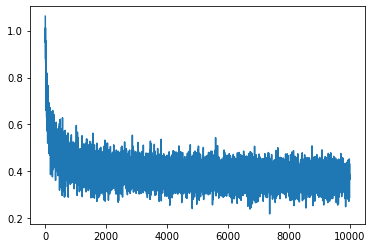

In [148]:
plt.plot(px, py)

In [201]:
#t = torch.randint(0, len(devX), (32,))
logits1 = torch.tanh(devX @ w1 + b1)
logits2 = logits1 @ w2 + b2
loss = F.cross_entropy(logits1, devY)
print(loss.item())

4.271421432495117


In [169]:
t = torch.randint(0, len(trainX), (32,))
logits1 = torch.tanh(trainX[t] @ w1 + b1)
logits2 = logits1 @ w2 + b2
loss = F.cross_entropy(logits2, trainY[t])
print(loss.item())

2.6370086669921875


In [79]:
t = torch.randint(0, len(trainX), (32,))
min(t)

tensor(3366)

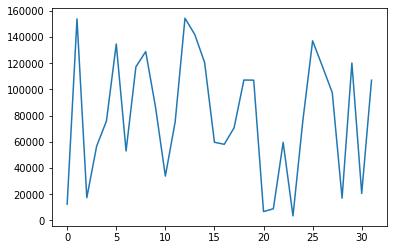

In [80]:
plt.plot(t)

In [174]:
devX[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [173]:
trainX[0]

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [193]:
C = torch.randint(27,(27,))
X = torch.tensor([0, 1])

In [195]:
X

tensor([0, 1])

In [196]:
C[X]

tensor([23,  8])

In [194]:
C

tensor([23,  8,  0,  4, 11,  3, 11, 13,  4, 18,  2,  7,  5,  9, 10, 20,  6,  4,
        23, 11,  6, 10, 19, 23, 20, 19,  4])